# Machine learning for genetic data — Part 1: GWAS data and classical analysis

## Introduction

The goal of this practical session is to manipulate high-dimensional, low sample-size data that is typical of many genetic applications.

Here we will work with GWAS data from _Arabidopsis thaliana_, which is a plant model organism (https://upload.wikimedia.org/wikipedia/commons/6/6f/Arabidopsis_thaliana.jpg).

The genotypes are hence described by **Single Nucleotide Polymorphisms, or SNPs**. Our goal will be to use this data to identify regions of the genome that can be linked with various growth and flowering traits (**phenotypes**).

## Libraries

Let us start by loading some useful libraries.

In [1]:
# make sure graphics are displayed inline (rather than opened in new windows)
%matplotlib inline 

# imports
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pandas as pd

In [3]:
plt.rc('font', **{'size': 14}) # font size for text on plots

## Data description

* `data/athaliana_small.genotype.txt` is the genotype data. SNPs are encoded by 0 (major allele) or 1 (minor allele). Because _A. thaliana_ lines are almost completely inbred, most SNPs are homozygous, and the experiment that led to this data only called homozygous SNPs. Note that this is not a real GWAS dataset, which would have hundreds of thousands of SNPs, but a scaled-down version with much fewer SNPs that can more easily be handled in the course of this practical.

* the phenotypes are given in `data/athaliana_small.4W.pheno` and `data/athaliana_small.2W.pheno`. The first column is the sample's ID, and the second the phenotype. The two phenotypes are the number of days required for the bolt height to reach 5cm, after seeds have been vernalized for 2 (2W) or 4 (4W) weeks.

* `data/candidates_genes.txt` contains a list of _A. thaliana_ genes known or strongly suspected to be associated with flowering times.

* `data/snps_by_gene.txt` list, for almost 26 000 _A. thaliana_ genes, the SNPs that are in or near those genes (on the DNA sequence).

* the feature network is in `data/athaliana_small.W.txt`. It has been saved as 3 arrays, corresponding to the row, col, and data attributes of a [scipy.sparse coo_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html). We will not use it in the first practical.

## Load the data

#### Load the genotype data
Let us load the genotype data as a panda DataFrame `genotype_df`

In [4]:
genotype_df = pd.read_csv("data/athaliana_small.genotype.txt")

We can inspect the data:

In [5]:
genotype_df.head()

,Sample,Chr1_21043_T,Chr1_21128_T,Chr1_21829_C,Chr1_22522_G,Chr1_27265_C,Chr1_29291_A,Chr1_31515_G,Chr1_32807_A,Chr1_35856_C,...,Chr5_26789553_C,Chr5_26790454_C,Chr5_26790630_A,Chr5_26791907_T,Chr5_26796983_C,Chr5_26798798_T,Chr5_26802144_C,Chr5_26802523_C,Chr5_26804767_C,Chr5_26804816_T
0,9381,0,0,0,1,1,1,0,0,0,...,0,1,1,0,0,0,0,0,0,0
1,9380,0,1,1,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,9378,0,0,1,1,1,0,0,0,0,...,1,1,1,1,0,0,0,0,1,1
3,9371,0,0,1,1,1,0,0,0,0,...,1,0,1,1,0,0,0,0,1,1
4,9367,0,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


Each line describes a sample (a plant), and each column a SNP (except for the first one, which gives the sample name). SNPs are identified by chromosome number + position on the chromosome (bp) + major allele.

Let us use the column "Sample" to index our DataFrame:

In [6]:
genotype_df = genotype_df.set_index("Sample")

We can now check the shape of our DataFrame:

In [7]:
genotype_df.shape

(1307, 9419)

__Q: How many samples are there in the data? How many SNPs/features?__

__Answer:__



#### Load the 2W phenotype data
We can now load the phenotype data in a pandas DataFrame `phenotype_df`. 

In [8]:
phenotype_df = pd.read_csv('data/athaliana_small.2W.pheno', delim_whitespace=True)

In [9]:
phenotype_df.head()

,FID,IID,2W
0,5837,5837,28.0
1,6008,6008,16.0
2,6009,6009,125.0
3,6016,6016,78.2
4,6040,6040,72.4


You can safely ignore the first column. The second ("IID") is the sample ID (or Individual ID) and the third is the phenotype.

The 2W phenotype is not available for all samples:

In [10]:
print(f"The 2W phenotype is available for {len(phenotype_df['IID'])} samples.")

The 2W phenotype is available for 152 samples.


#### Create a data matrix and response vector
From a machine learning point of view, we want to deal with a data matrix `X` (a 2-dimensional numpy array) with as many lines as samples and as many columns as features/SNPs, and a response vector `y` (a 1-dimensional numpy array) with as many entries as samples. 

The response vector is simply the "2W" column of `phenotype_df`:

In [11]:
y_2W = np.array(phenotype_df["2W"])

In [12]:
y_2W.shape

(152,)

To create the data matrix, we need to restrict the genotype to the samples for which we have a phenotype (in the same order):

In [13]:
X_2W = np.array(genotype_df.loc[phenotype_df["IID"]])

__Q: How many samples do we have now? And how many SNPs? Does this make the task of biomarker detection simpler or harder?__

__Answer:__



#### Load the list of candidate genes

In [14]:
with open('data/candidate_genes.txt') as f:
    candidate_genes = f.readline().split()
    f.close()

#### Load the SNPs-to-gene mapping
The SNPs in our data set have been mapped to genes based on their genomic position. Let us load this information into a dictionary:

In [15]:
genes_by_snp = {} # key: SNP, value = [genes in/near which this SNP is]
with open('data/snps_by_gene.txt') as f:
    for line in f:
        ls = line.split()
        gene_id = ls[0]
        for snp_id in ls[1:]:
            if not snp_id in genes_by_snp:
                genes_by_snp[snp_id] = []
            genes_by_snp[snp_id].append(gene_id) 

## Visualize the data

Let us first visualize the distribution of the phenotypes:

Text(0, 0.5, 'Number of samples')

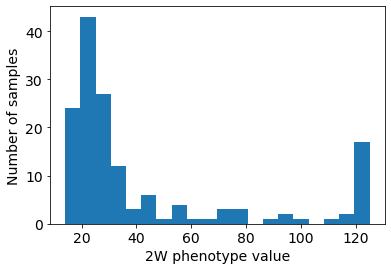

In [16]:
h = plt.hist(y_2W, bins=20)
plt.xlabel("2W phenotype value")
plt.ylabel("Number of samples")

Let us now visualize the correlation structure of the genotypes. We'll restrict ourselves to looking at the first 1,000 SNPs in the data to accelerate computations.

In [17]:
# Compute the correlation matrix for the first 1,000 SNPs in the data
sigma = pd.DataFrame(X_2W[:, :1000]).corr()

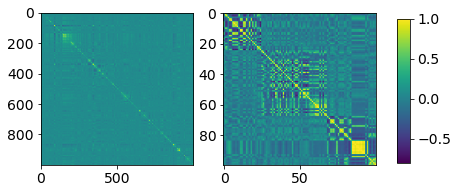

In [18]:
# Prepare to make 1 row of 2 subplots
fig, ax = plt.subplots(1, 2, figsize=(6, 10), gridspec_kw={'width_ratios': [1, 1]})

# Correlation structure for the first 1,000 SNPs
# This computation can take time, reduce it to the first 500 SNPs if needed
im = ax[0].imshow(sigma.iloc[:1000, :1000])

# Correlation structure for the first 100 SNPs
im = ax[1].imshow(sigma.iloc[:100, :100])
plt.colorbar(im, cax=fig.add_axes([0.95, 0.4, 0.03, 0.2]))

__Q: What observation can you make about the phenotype and genotype?__

## T-test

Let us start by running a statistical test for association of each SNP feature with the phenotype.

In [19]:
import statsmodels.api as sm

### T-test on a single SNP
We will perform a linear regression on a single SNP and test whether this SNP has an effect on the phenotype.

In [20]:
est = sm.regression.linear_model.OLS(y_2W, sm.add_constant(X_2W[:, 0])).fit()
print(est.summary2())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.3813
Date:                Fri, 25 Mar 2022   Prob (F-statistic):              0.538
Time:                        15:34:58   Log-Likelihood:                -757.19
No. Observations:                 152   AIC:                             1518.
Df Residuals:                     150   BIC:                             1524.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         44.8370      3.549     12.635      0.0

__Q: In the previous table, where is the p-value of the T-test? What can you conclude about the effect of the first SNP on the phenotype?__

__Answer:__



We can also visualize the linear regression that gave us this p-value:

Text(0, 0.5, 'Phenotype')

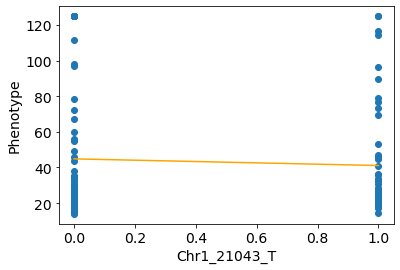

In [21]:
# Visualize the phenotype as a function of the first SNP
plt.scatter(X_2W[:, 0], y_2W)

# Add the regression line 
plt.plot([0, 1], [est.params[0], (est.params[0] + est.params[1])], color='orange')

plt.xlabel(genotype_df.columns[0])
plt.ylabel("Phenotype")

__Q: Looking at this plot, do you think there is a significant relationship between the first SNP of the data and the phenotype? Does this match your previous answer?__

__Answer:__



### T-test on all SNPs

We can now do the same thing for all SNPs in the data:

In [22]:
num_snps = X_2W.shape[1]

In [203]:
pvalues = []
for snp_idx in range(num_snps):
    # only look a the column corresponding to that SNP
    X_snp = X_2W[:, snp_idx]
    
    # run a linear regression (with bias) between the phenotype and this SNP
    X_snp = sm.add_constant(X_snp)
    est = sm.regression.linear_model.OLS(y_2W, X_snp)
    est = est.fit()
    
    # get the p-value from the model 
    pvalues.append(est.pvalues[1])

# convert the list of p-values to a numpy array
pvalues = np.array(pvalues)

### Manhattan plot

The common way to visualize such results is by using a Manhattan plot: we will plot all SNPs on the x-axis, and on the y-axis we'll have the opposite of the log base 10 of the p-value. The lower the p-value, the higher the corresponding marker. 

We will also add a horizontal line that corresponds to the _threshold for significance_. Because we are testing multiple hypotheses, we need to lower our threshold accordingly. We will use __Bonferroni correction__ and divide the significance threshold (say, alpha=0.05) by the number of tests, that is, the number of SNPs p.

(0.0, 9419.0)

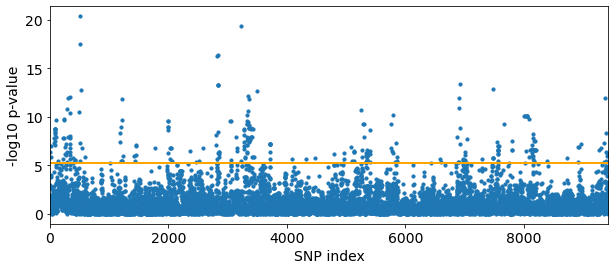

In [204]:
plt.figure(figsize = (10, 4))

plt.scatter(range(num_snps), -np.log10(pvalues), s=10)

# significance threshold according to Bonferroni correction
t = -np.log10(0.05 / num_snps)
plt.plot([0, num_snps], [t, t], color='orange', lw=2)

# plot labels
plt.xlabel("SNP index")
plt.ylabel("-log10 p-value")
plt.xlim([0, num_snps])

We can also display each chromosome in a different color

In [205]:
# Identify the indices at which we change chromosomes
last_snp_of_a_chr = []
current_chr_idx = 1
for snp_idx, snp_name in enumerate(genotype_df.columns):
    chr_idx = int(snp_name[3])
    if chr_idx > current_chr_idx: # we changed chromosomes
        last_snp_of_a_chr.append(snp_idx)
        current_chr_idx = chr_idx
last_snp_of_a_chr.append(snp_idx+1) # add the last index

(0.0, 9419.0)

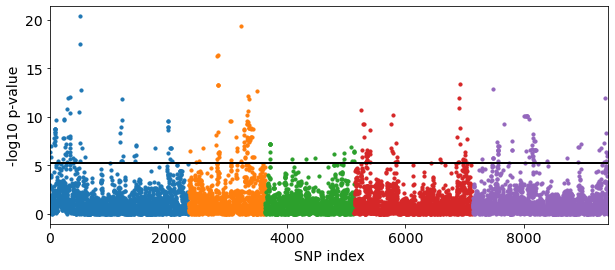

In [207]:
plt.figure(figsize = (10, 4))

first_snp_idx = 0
for chr_idx, last_snp_idx in enumerate(last_snp_of_a_chr):
    plt.scatter(range(first_snp_idx, last_snp_idx), -np.log10(pvalues[first_snp_idx: last_snp_idx]), s=10)
    first_snp_idx = last_snp_idx+1
    
# significance threshold according to Bonferroni correction
significance_thr = 0.05 / num_snps
t = -np.log10(significance_thr)
plt.plot([0, num_snps], [t, t], color='black', lw=2)

# plot labels
plt.xlabel("SNP index")
plt.ylabel("-log10 p-value")
plt.xlim([0, num_snps])

__Q: What do you observe? Are any SNPs significantly associated with the phenotype?__

__Answer:__



## Population stratification

### QQ-plot

The reason why we found so many SNPs associated with the phenotype is a phenomenon called _population stratification_: both the genotypes and the phenotype are correlated to a hidden confounding variable, which is the population to which the plants belong. This leads to an overestimation of the significance of the SNPs.

This can be observed on a Q-Q plot: we expect most SNPs to be non-significant, so the distribution of p-values should be close to uniform.

In [208]:
# Draw a random sample of size num_snps from a uniform distribution
uniform_sample = -np.log10(np.random.uniform(size=(num_snps, )))

# Compute 100 quantiles for this random sample
q_list = np.linspace(0., 1., num=100)
uniform_quantiles = [np.quantile(uniform_sample, q) for q in q_list]

# Compute the same quantiles for the p-value
pvalues_quantiles = [np.quantile(-np.log10(pvalues), q) for q in q_list]

Text(0.5, 1.0, 'QQ plot for -log10(pvalues)')

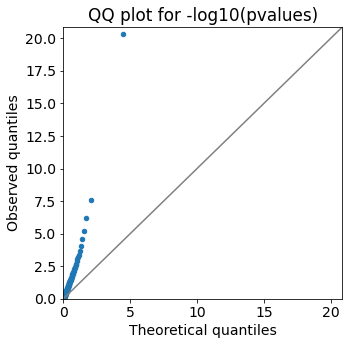

In [230]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(uniform_quantiles, pvalues_quantiles, s=20)
max_value = np.max(pvalues_quantiles) + 0.5
plt.plot([0, max_value], [0, max_value], color='gray')
plt.xlabel("Theoretical quantiles")
plt.ylabel("Observed quantiles")
plt.xlim([0, max_value])
plt.ylim([0, max_value])
plt.title("QQ plot for -log10(pvalues)")

__Q: What do you observe? Are the p-values overinflated?__

__Answer:__



### Genomic inflation

In case-control studies, we use a chi-square test of association (appropriate for _categorical_ variables) rather than a t-test (appropriate to test for independence between one categorical and one continuous variable). The overinflation of test statistics is measured with the __genomic inflation factor__ $\lambda_{gc}$, which is the ratio between the median of the values of the chi-square test statistics and their expected median, which is the median of a chi-square distribution with one degree of freedom. 

See Devlin and Roeder (1999): https://pubmed.ncbi.nlm.nih.gov/11315092/

This approach can be extended to comparing -log10 of the median of the p-values with -log10 of their expected median (which is 0.5):

In [221]:
lambda_gc = np.median(np.log10(pvalues))/np.log10(0.5)
print(f"The genomic inflation factor is {lambda_gc:.2f}")

The genomic inflation factor is 2.63


(0.0, 20.861596680538263)

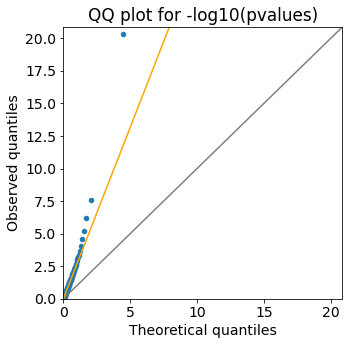

In [222]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(uniform_quantiles, pvalues_quantiles, s=20)
max_value = np.max(pvalues_quantiles) + 0.5
plt.plot([0, max_value], [0, max_value], color='gray')
plt.plot([0, max_value], [0, max_value*lambda_gc], color='orange')
plt.xlabel("Theoretical quantiles")
plt.ylabel("Observed quantiles")
plt.title("QQ plot for -log10(pvalues)")
plt.xlim([0, max_value])
plt.ylim([0, max_value])

### PCA-based adjustement

One option to correct for population stratification is to compute principal components of the genotype as proxy for the population structure, and regress them out from the phenotype.

In [223]:
from sklearn import decomposition, linear_model

In [266]:
# Compute the first 4 principal components
pca = decomposition.PCA(n_components=5)
pca.fit(X_2W)
principal_components = X_2W.dot(pca.components_.T) 

In [267]:
# Fit a linear model between the phenotype and the principal components
model = linear_model.LinearRegression()
model.fit(principal_components, y_2W)

# Compute the model's residuals
y_pred = model.predict(principal_components)
y_2W_corrected = y_2W - y_pred

We can now visualize the corrected phenotype:

Text(0, 0.5, 'Number of samples')

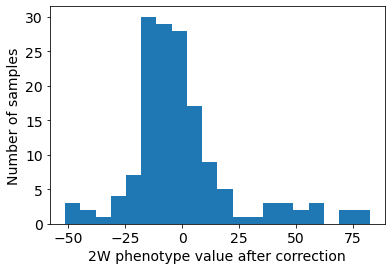

In [268]:
h = plt.hist(y_2W_corrected, bins=20)
plt.xlabel("2W phenotype value after correction")
plt.ylabel("Number of samples")

And now we compute our p-values again:

In [269]:
adjusted_pvalues = []
for snp_idx in range(num_snps):
    # only look a the column corresponding at that SNP
    X_snp = X_2W[:, snp_idx]
    
    # run a linear regression (with bias) between the phenotype and this SNP
    X_snp = sm.add_constant(X_snp)
    est = sm.regression.linear_model.OLS(y_2W_corrected, X_snp)
    est = est.fit()
    
    # get the p-value from the model 
    adjusted_pvalues.append(est.pvalues[1])

# convert the list of p-values to a numpy array
adjusted_pvalues = np.array(adjusted_pvalues)

We compute the genomic inflation factor:

In [270]:
lambda_gc = np.median(np.log10(adjusted_pvalues))/np.log10(0.5)
print(f"After adjustment, the genomic inflation factor is {lambda_gc:.2f}")

After adjustment, the genomic inflation factor is 1.17


__Comment:__ Although it is milder, we still observe overinflation, because we have few SNPs and a larger proportion of them are associated with the phenotype than on a real GWAS. In a real GWAS, we would want to keep the genomic inflation factor under 1.1.

And the new QQ-plot:

In [271]:
# Recompute the quantiles for the new p-value
adjusted_pvalues_quantiles = [np.quantile(-np.log10(adjusted_pvalues), q) for q in q_list]

Text(0.5, 1.0, 'QQ plot for -log10(pvalues) after correction')

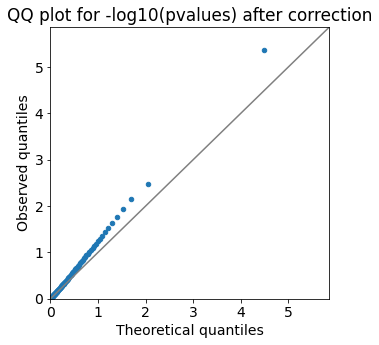

In [272]:
fig = plt.figure(figsize=(5, 5))

plt.scatter(uniform_quantiles, adjusted_pvalues_quantiles, s=20)

max_value = np.max(adjusted_pvalues_quantiles) + 0.5
plt.plot([0, max_value], [0, max_value], color='gray')
plt.xlabel("Theoretical quantiles")
plt.ylabel("Observed quantiles")
plt.xlim([0, max_value])
plt.ylim([0, max_value])
plt.title("QQ plot for -log10(pvalues) after correction")

Finally, here is the new Manhattan plot:

(0.0, 9419.0)

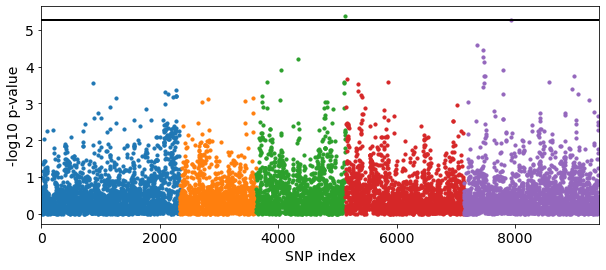

In [273]:
plt.figure(figsize = (10, 4))

first_snp_idx = 0
for chr_idx, last_snp_idx in enumerate(last_snp_of_a_chr):
    plt.scatter(range(first_snp_idx, last_snp_idx), -np.log10(adjusted_pvalues[first_snp_idx: last_snp_idx]), s=10)
    first_snp_idx = last_snp_idx+1
    
# significance threshold according to Bonferroni correction
significance_thr = 0.05 / num_snps
t = -np.log10(significance_thr)
plt.plot([0, num_snps], [t, t], color='black', lw=2)

# plot labels
plt.xlabel("SNP index")
plt.ylabel("-log10 p-value")
plt.xlim([0, num_snps])

__Q: What do you observe? Are any SNPs significantly associated with the phenotype?__

__Answer:__



Let us now list the SNPs that are significantly associated with the phenotype and see whether they point to candidate genes:

In [274]:
significant_snp_indices = np.where(adjusted_pvalues < significance_thr)[0]
print(f"We found {len(significant_snp_indices)} SNP(s) significantly associated with the phenotype.")

We found 1 SNP(s) significantly associated with the phenotype.


In [275]:
print(genotype_df.columns[significant_snp_indices])

Index(['Chr3_23008395_C'], dtype='object')


In [276]:
significant_candidate_genes = []
num_snps_pointing_to_candidates = 0
for snp_name in genotype_df.columns[significant_snp_indices]:
    matching_genes = genes_by_snp[snp_name]
    candidate_matching_genes = set(matching_genes).intersection(set(candidate_genes))
    if len(candidate_matching_genes):
        num_snps_pointing_to_candidates += 1
        significant_candidate_genes.extend(candidate_matching_genes)
print(f"{num_snps_pointing_to_candidates} of the {len(significant_snp_indices)} significant SNP(s) point to {len(significant_candidate_genes)} candidate genes.")

1 of the 1 significant SNP(s) point to 1 candidate genes.


In [277]:
print(significant_candidate_genes)

['AT3G62090']


__Optional questions:__ 
* Observe how changing the number of principal components affects the results.
* Use [TAIR](https://www.arabidopsis.org/servlets/Search?search_action=new_search&type=gene) to learn more about specific _A. thaliana_ genes.

## Split the data in a train and test set

To estimate the predictive power of a model, we always split the data into a *train* set, which serves to fit the model, and a *test* set, which serves to measure the model's performance.

__Q: Why is that? What happens if we perform both the training and testing on the same data?__

**Answer:**



We will set aside a test set, containing 20% of our samples, on which to evaluate the quality of our predictive models.

__Q: What problem occurs if we set a test set that is too large in proportion? What problem occurs when it is set too small?__

**Answer:**



In [278]:
from sklearn import model_selection

Using `random_state` inside a function that uses a random generator ensures that we obtain the same result whenever we call this function with the same value of `random_state`. This way, we'll be working with the same train/test split even if we re-run our notebook. This is good practice for reproducibility of results.

In [279]:
X_2W_tr, X_2W_te, y_2W_tr, y_2W_te = \
    model_selection.train_test_split(X_2W, y_2W_corrected, test_size=0.2, random_state=42)
print(f"Training set shape: {X_2W_tr.shape}\nTest set shape: {X_2W_te.shape}")

Training set shape: (121, 9419)
Test set shape: (31, 9419)


## Multivariate linear regression 
We will now fit a linear regression _simultaneously_ on all SNPs:

In [280]:
model_lr = linear_model.LinearRegression(fit_intercept=True)
model_lr.fit(X_2W_tr, y_2W_tr)

LinearRegression()

Let us plot the regression weights:

Text(0.5, 1.0, 'Regression coefficients of a linear regression')

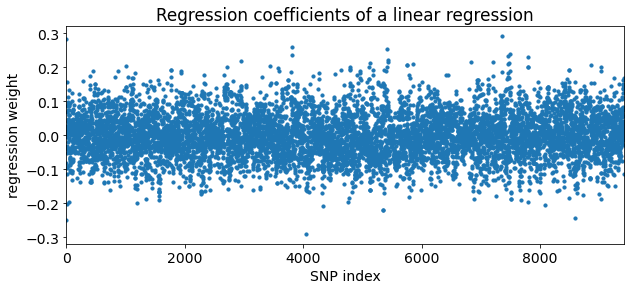

In [281]:
plt.figure(figsize = (10, 4))
plt.scatter(range(num_snps), model_lr.coef_, s=10)

plt.xlabel("SNP index")
plt.ylabel("regression weight")
plt.xlim([0, num_snps])
plt.title("Regression coefficients of a linear regression")

__Q: What do you observe? How can you interpret these results? Do any of the SNPs strike you as having a strong influence on the phenotype?__

__Answer:__



Let us find which two SNPs have the highest regression weights (in absolute value):

In [282]:
genotype_df.columns[np.argsort(np.abs(model_lr.coef_))[::-1][:2]]

Index(['Chr5_1168046_T', 'Chr3_3652430_A'], dtype='object')

__Q: Compare these results to those obtained with individual statistical tests__

__Answer:__



### Quality of model fit

Let us evaluate how well our model fits the data it was trained on.

__Q: What is the definition of the variance explained? You may use the [scikit learn documentation](https://sklearn.org/modules/classes.html#sklearn-metrics-metrics). What values can this metric take? and to what cases do the extreme values correspond to?__

**Answer:**

In [283]:
from sklearn import metrics

In [284]:
y_2W_lr_pred = model_lr.predict(X_2W_tr)
pve = metrics.explained_variance_score(y_2W_tr, y_2W_lr_pred) * 100
print(f"The percentage of variance explained by a linear regression using all SNPs is {pve:.0f}%")

The percentage of variance explained by a linear regression using all SNPs is 100%


We can also plot the predictions vs the true phenotype for all SNPs from the train set:

Text(0.5, 1.0, 'Goodness of fit of the lasso')

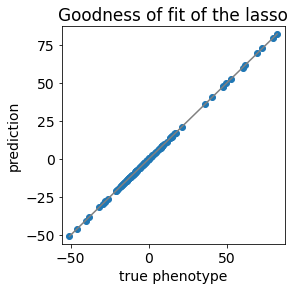

In [285]:
plt.figure(figsize = (4, 4))
plt.scatter(y_2W_tr, y_2W_lr_pred)

# plot a line y=x
x_min = np.min(y_2W_tr)
x_max = np.max(y_2W_tr)
plt.plot([x_min, x_max], [x_min, x_max], c='gray')

plt.xlabel("true phenotype")
plt.ylabel("prediction")
plt.xlim([x_min - 5, x_max + 5])
plt.ylim([x_min - 5, x_max + 5])

plt.title("Goodness of fit of the lasso")

__Q: How well does the model fit the training data? Is this surprising?__

**Answer:**

### Model predictive power

Let us now measure the performance of the linear model on the _test_ data set.

In [286]:
y_2W_lr_pred = model_lr.predict(X_2W_te)
pve = metrics.explained_variance_score(y_2W_te, y_2W_lr_pred) * 100
print(f"The percentage of variance explained by a linear regression using all SNPs is {pve:.0f}%")

The percentage of variance explained by a linear regression using all SNPs is 19%


And let us plot the predictions vs the true phenotype for all SNPs from the test set:

Text(0.5, 1.0, 'OLS regression')

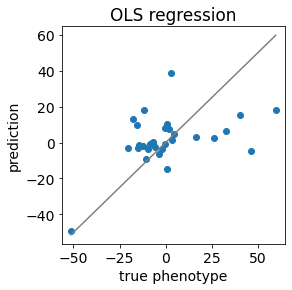

In [287]:
plt.figure(figsize = (4, 4))
plt.scatter(y_2W_te, y_2W_lr_pred)

# plot a line y=x
x_min = np.min(y_2W_te)
x_max = np.max(y_2W_te)
plt.plot([x_min, x_max], [x_min, x_max], c='gray')

plt.xlabel("true phenotype")
plt.ylabel("prediction")
plt.xlim([x_min - 5, x_max + 5])
plt.ylim([x_min - 5, x_max + 5])

plt.title("OLS regression")

__Q: How well does the model predict on the test data? Is this surprising?__

**Answer:**